#The goal here is to achieve 85% accuracy on the cifar 10 dataset using

- Depthwise Separable Convolution
- Dilated Convolution
- Not using Max Pooling
- Augmentation
-- horizontal flip
-- shiftScaleRotate
-- coarseDropout

In [1]:
!pip install --upgrade --force-reinstall --no-deps albumentations

  Using cached https://files.pythonhosted.org/packages/b0/be/3db3cd8af771988748f69eace42047d5edebf01eaa7e1293f3b3f75f989e/albumentations-1.0.0-py3-none-any.whl
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


In [2]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



# Imports

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
sys.path.insert(0,'/content/drive')

In [6]:
%cd /content/drive/My\ Drive
from model import Net

/content/drive/My Drive


# Custom Model

In [7]:
from model import Net 

In [8]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



# Loading Dataset

In [9]:
# Loading DataSet

In [10]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=12, max_width=12, min_holes = 1, min_height=1, min_width=1, fill_value=0.5, mask_fill_value = None),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ToTensorV2(),
    ]
)

'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
'''
trainset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = Cifar10SearchDataset(root='./data', train=False,
                                       download=True,transform = test_transform)
test_loader =torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



 deer   car horse   dog


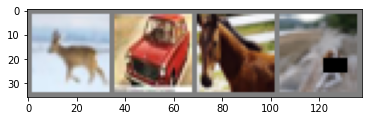

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [12]:
net = Net()

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
            Conv2d-2           [-1, 32, 32, 32]           4,608
       BatchNorm2d-3           [-1, 32, 32, 32]              64
              ReLU-4           [-1, 32, 32, 32]               0
           Dropout-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]              96
            Conv2d-7           [-1, 64, 15, 15]          18,432
            Conv2d-8          [-1, 128, 15, 15]          73,728
       BatchNorm2d-9          [-1, 128, 15, 15]             256
             ReLU-10          [-1, 128, 15, 15]               0
          Dropout-11          [-1, 128, 15, 15]               0
           Conv2d-12           [-1, 64, 11, 11]          73,728
           Conv2d-13             [-1, 32, 9, 9]          18,432
      BatchNorm2d-14             [

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [14]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [15]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Training functions

In [16]:
#Training functions

In [17]:
from tqdm import tqdm




def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    #train_losses.append(loss)
    train_loss = train_loss + loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_loss /= len(train_loader.dataset)
  train_acc.append(100*correct/processed)
  train_losses.append(train_loss)
  #train_losses.append(loss)

    #return train_acc, train_losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [18]:
def display_misclassified_images(model):
  print("\n\n\n********* Misclassified Images **************\n\n\n")
  model.eval()

  # Create a test loader with batch size equal to test data length
  #test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
  test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=transform)
  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=len(test), num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=len(test))
  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          # Get the indexes of images that are incorrectly classified
          indexes = (pred.view(-1,) != target.view(-1,)).nonzero()

          # Plot the misclassified images
          rows = np.ceil(len(indexes)/2)
          fig = plt.figure(figsize=(15, rows*4))
          for i, idx in enumerate(indexes[:10]):
              ax = fig.add_subplot(rows, 5, i+1)
              ax.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray_r',dpi=100)
              ax.set_title(f"Target = {target[idx].item()} \n Predicted = {pred[idx].item()}")
          
          plt.show()

# Training Loop

In [19]:
#def train_test_display(no_of_epochs):
EPOCHS = 50

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#learning_rate = 0.01
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
# LR Scheduler
lambda1 = lambda epoch: 0.85 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

for epoch in range(1,EPOCHS +1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    optimizer.step()
    test(model, device, test_loader)

#display_misclassified_images(model)

#return test_acc, test_losses,train_acc,train_losses

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.3616243600845337 Batch_id=390 Accuracy=38.37: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 4589/10000 (45.89%)

EPOCH: 2


Loss=1.2903900146484375 Batch_id=390 Accuracy=54.07: 100%|██████████| 391/391 [00:11<00:00, 35.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 5783/10000 (57.83%)

EPOCH: 3


Loss=0.8459411859512329 Batch_id=390 Accuracy=61.11: 100%|██████████| 391/391 [00:11<00:00, 35.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6167/10000 (61.67%)

EPOCH: 4


Loss=1.0582202672958374 Batch_id=390 Accuracy=64.56: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6717/10000 (67.17%)

EPOCH: 5


Loss=0.9144412279129028 Batch_id=390 Accuracy=67.79: 100%|██████████| 391/391 [00:11<00:00, 35.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7132/10000 (71.32%)

EPOCH: 6


Loss=0.875543475151062 Batch_id=390 Accuracy=69.60: 100%|██████████| 391/391 [00:11<00:00, 34.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 7086/10000 (70.86%)

EPOCH: 7


Loss=0.9087523221969604 Batch_id=390 Accuracy=71.05: 100%|██████████| 391/391 [00:11<00:00, 35.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7187/10000 (71.87%)

EPOCH: 8


Loss=0.7223751544952393 Batch_id=390 Accuracy=72.35: 100%|██████████| 391/391 [00:11<00:00, 35.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7426/10000 (74.26%)

EPOCH: 9


Loss=0.6854380965232849 Batch_id=390 Accuracy=73.19: 100%|██████████| 391/391 [00:11<00:00, 34.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7604/10000 (76.04%)

EPOCH: 10


Loss=0.8621746897697449 Batch_id=390 Accuracy=74.53: 100%|██████████| 391/391 [00:11<00:00, 34.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7679/10000 (76.79%)

EPOCH: 11


Loss=0.5989867448806763 Batch_id=390 Accuracy=74.71: 100%|██████████| 391/391 [00:11<00:00, 35.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7772/10000 (77.72%)

EPOCH: 12


Loss=0.5655485391616821 Batch_id=390 Accuracy=76.12: 100%|██████████| 391/391 [00:11<00:00, 35.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7666/10000 (76.66%)

EPOCH: 13


Loss=0.7895005941390991 Batch_id=390 Accuracy=76.18: 100%|██████████| 391/391 [00:11<00:00, 35.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7840/10000 (78.40%)

EPOCH: 14


Loss=0.5183305144309998 Batch_id=390 Accuracy=77.13: 100%|██████████| 391/391 [00:11<00:00, 35.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7899/10000 (78.99%)

EPOCH: 15


Loss=0.5472713112831116 Batch_id=390 Accuracy=77.48: 100%|██████████| 391/391 [00:11<00:00, 35.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7812/10000 (78.12%)

EPOCH: 16


Loss=0.408999502658844 Batch_id=390 Accuracy=77.81: 100%|██████████| 391/391 [00:10<00:00, 35.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7760/10000 (77.60%)

EPOCH: 17


Loss=0.9425004124641418 Batch_id=390 Accuracy=78.56: 100%|██████████| 391/391 [00:11<00:00, 35.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7852/10000 (78.52%)

EPOCH: 18


Loss=0.7217897176742554 Batch_id=390 Accuracy=78.64: 100%|██████████| 391/391 [00:11<00:00, 35.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7953/10000 (79.53%)

EPOCH: 19


Loss=0.6526190042495728 Batch_id=390 Accuracy=79.04: 100%|██████████| 391/391 [00:11<00:00, 35.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7927/10000 (79.27%)

EPOCH: 20


Loss=0.4442247748374939 Batch_id=390 Accuracy=79.47: 100%|██████████| 391/391 [00:11<00:00, 35.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7847/10000 (78.47%)

EPOCH: 21


Loss=0.4218319356441498 Batch_id=390 Accuracy=79.86: 100%|██████████| 391/391 [00:11<00:00, 35.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8072/10000 (80.72%)

EPOCH: 22


Loss=0.6574229001998901 Batch_id=390 Accuracy=79.90: 100%|██████████| 391/391 [00:11<00:00, 35.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8182/10000 (81.82%)

EPOCH: 23


Loss=0.597236692905426 Batch_id=390 Accuracy=80.09: 100%|██████████| 391/391 [00:10<00:00, 35.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8138/10000 (81.38%)

EPOCH: 24


Loss=0.576559841632843 Batch_id=390 Accuracy=80.61: 100%|██████████| 391/391 [00:10<00:00, 35.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8223/10000 (82.23%)

EPOCH: 25


Loss=0.5489528775215149 Batch_id=390 Accuracy=80.48: 100%|██████████| 391/391 [00:11<00:00, 35.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8057/10000 (80.57%)

EPOCH: 26


Loss=0.6187418699264526 Batch_id=390 Accuracy=81.09: 100%|██████████| 391/391 [00:11<00:00, 35.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8041/10000 (80.41%)

EPOCH: 27


Loss=0.5735852122306824 Batch_id=390 Accuracy=81.39: 100%|██████████| 391/391 [00:10<00:00, 35.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8164/10000 (81.64%)

EPOCH: 28


Loss=0.5412876605987549 Batch_id=390 Accuracy=81.43: 100%|██████████| 391/391 [00:11<00:00, 35.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8212/10000 (82.12%)

EPOCH: 29


Loss=0.454658567905426 Batch_id=390 Accuracy=81.75: 100%|██████████| 391/391 [00:11<00:00, 35.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8253/10000 (82.53%)

EPOCH: 30


Loss=0.6937731504440308 Batch_id=390 Accuracy=81.86: 100%|██████████| 391/391 [00:11<00:00, 35.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8294/10000 (82.94%)

EPOCH: 31


Loss=0.5531013607978821 Batch_id=390 Accuracy=82.04: 100%|██████████| 391/391 [00:11<00:00, 35.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8328/10000 (83.28%)

EPOCH: 32


Loss=0.5086328983306885 Batch_id=390 Accuracy=82.22: 100%|██████████| 391/391 [00:10<00:00, 35.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8340/10000 (83.40%)

EPOCH: 33


Loss=0.4308083653450012 Batch_id=390 Accuracy=82.35: 100%|██████████| 391/391 [00:11<00:00, 34.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8365/10000 (83.65%)

EPOCH: 34


Loss=0.5718369483947754 Batch_id=390 Accuracy=82.58: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8423/10000 (84.23%)

EPOCH: 35


Loss=0.411592960357666 Batch_id=390 Accuracy=82.73: 100%|██████████| 391/391 [00:11<00:00, 35.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8429/10000 (84.29%)

EPOCH: 36


Loss=0.5408097505569458 Batch_id=390 Accuracy=82.90: 100%|██████████| 391/391 [00:11<00:00, 35.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8387/10000 (83.87%)

EPOCH: 37


Loss=0.47667431831359863 Batch_id=390 Accuracy=83.01: 100%|██████████| 391/391 [00:11<00:00, 35.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8411/10000 (84.11%)

EPOCH: 38


Loss=0.5939132571220398 Batch_id=390 Accuracy=83.20: 100%|██████████| 391/391 [00:11<00:00, 35.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8383/10000 (83.83%)

EPOCH: 39


Loss=0.5559241771697998 Batch_id=390 Accuracy=83.17: 100%|██████████| 391/391 [00:11<00:00, 35.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8477/10000 (84.77%)

EPOCH: 40


Loss=0.4638153612613678 Batch_id=390 Accuracy=83.31: 100%|██████████| 391/391 [00:11<00:00, 34.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8474/10000 (84.74%)

EPOCH: 41


Loss=0.4561111330986023 Batch_id=390 Accuracy=83.57: 100%|██████████| 391/391 [00:11<00:00, 35.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8332/10000 (83.32%)

EPOCH: 42


Loss=0.3844226002693176 Batch_id=390 Accuracy=83.64: 100%|██████████| 391/391 [00:11<00:00, 34.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8411/10000 (84.11%)

EPOCH: 43


Loss=0.4064803719520569 Batch_id=390 Accuracy=83.81: 100%|██████████| 391/391 [00:11<00:00, 35.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8334/10000 (83.34%)

EPOCH: 44


Loss=0.3490757346153259 Batch_id=390 Accuracy=83.79: 100%|██████████| 391/391 [00:11<00:00, 35.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8406/10000 (84.06%)

EPOCH: 45


Loss=0.4174632430076599 Batch_id=390 Accuracy=84.22: 100%|██████████| 391/391 [00:11<00:00, 34.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8445/10000 (84.45%)

EPOCH: 46


Loss=0.47883373498916626 Batch_id=390 Accuracy=83.93: 100%|██████████| 391/391 [00:11<00:00, 35.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8484/10000 (84.84%)

EPOCH: 47


Loss=0.34756025671958923 Batch_id=390 Accuracy=84.21: 100%|██████████| 391/391 [00:11<00:00, 35.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8520/10000 (85.20%)

EPOCH: 48


Loss=0.39172428846359253 Batch_id=390 Accuracy=84.34: 100%|██████████| 391/391 [00:11<00:00, 35.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8439/10000 (84.39%)

EPOCH: 49


Loss=0.49151960015296936 Batch_id=390 Accuracy=84.19: 100%|██████████| 391/391 [00:11<00:00, 35.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8399/10000 (83.99%)

EPOCH: 50


Loss=0.4402956962585449 Batch_id=390 Accuracy=84.67: 100%|██████████| 391/391 [00:11<00:00, 34.63it/s]



Test set: Average loss: 0.0037, Accuracy: 8422/10000 (84.22%)



In [20]:

#test_acc_f, test_losses_f,train_acc_f,train_losses_f = train_test_display(EPOCHS)

Text(0.5, 1.0, 'Loss')

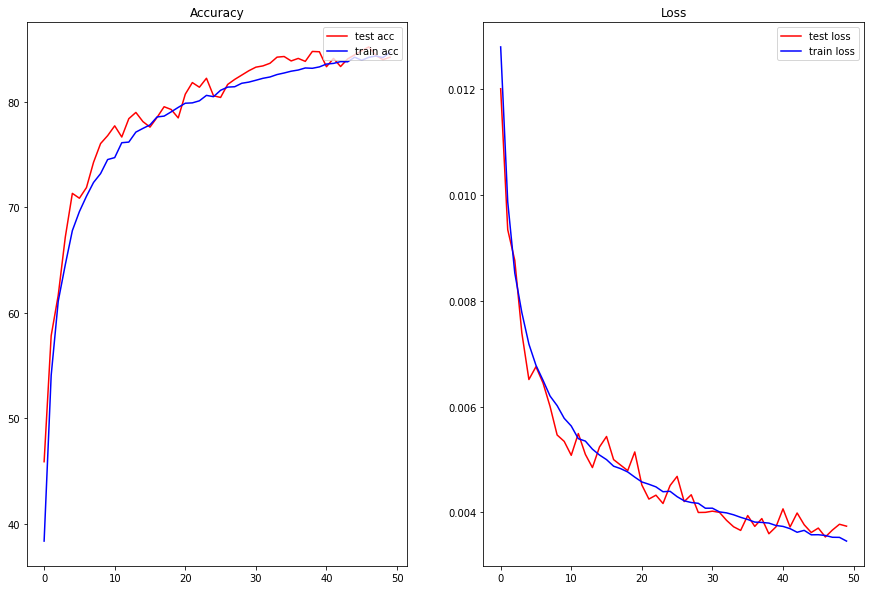

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs =[x for x in range(EPOCHS)]
fig, axs = plt.subplots(1,2,figsize=(15,10))
axs[0].plot(epochs,test_acc,'-r',label='test acc')
axs[0].plot(epochs,train_acc,'-b',label='train acc')
axs[0].legend(loc="upper right")
axs[0].set_title("Accuracy")

epochs =[x for x in range(EPOCHS)]
axs[1].plot(epochs,test_losses,'r',label='test loss')
axs[1].plot(epochs,train_losses,'b',label='train loss')
axs[1].legend(loc="upper right")
axs[1].set_title("Loss")